In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [20]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [21]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)


2017-08-23


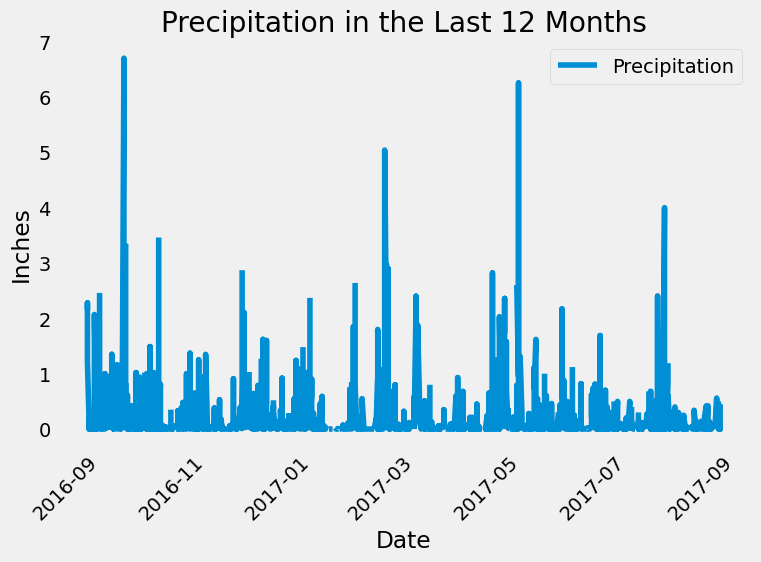

In [25]:
# Ensure recent_date is already in datetime format
if isinstance(recent_date, str):  # Convert only if it's a string
    recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in the data set
last_year_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_last_year = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= last_year_date)
    .all()
)

# Convert query results into a Pandas DataFrame
data_frame = pd.DataFrame(data_last_year, columns=["Date", "Precipitation"])

# Convert Date column to datetime format if it's not already
data_frame["Date"] = pd.to_datetime(data_frame["Date"])

# Sort the DataFrame by date
data_frame = data_frame.sort_values(by="Date")

# Plot the data
data_frame.plot(x="Date", y="Precipitation", kind="line", figsize=(8, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation in the Last 12 Months")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = data_frame['Precipitation'].describe()
print(summary_statistics.to_string())


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.id)).scalar()
print(num_stations)


9


In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the station ids and their counts of rows, ordered by count in descending order

# Query to fetch the all the station ids and their counts
station_count_query = session.query(Measurement.station, func.count(Measurement.station))
# groups the results by the station columns
grouped_by_station = station_count_query.group_by(Measurement.station)
# sort the results in descending order
ordered_stations = grouped_by_station.order_by(func.count(Measurement.station).desc())
# Fetch all the results
most_active_stations = ordered_stations.all()

print(most_active_stations)



[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_statistics = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

print(temperature_statistics)



[(54.0, 85.0, 71.66378066378067)]


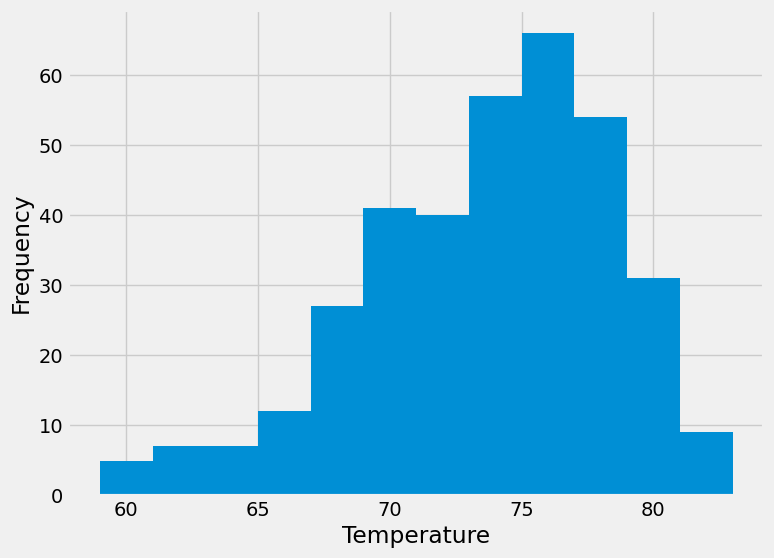

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the Measurement table for the maximum date value.
# Only include the station  which matches the most active station
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()

# Convert the most recent date to python DateTime Object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Get date 1 year ago from the most recent date
last_year_date = most_recent_date - dt.timedelta(days=365)

# Query the Measurement table to fetch two columns, date and tobs.
# Only include station which matches the most active station and include only the rows
# which where measured in the last year.
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= last_year_date
).all()

# Plot the results
temperature_data_frame = pd.DataFrame(temperature_data, columns=['tobs'])
plt.figure(figsize=(8, 6))
temperature_data_frame['tobs'].plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()




# Close Session

In [30]:
# Close Session
session.close()